In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import tol_colors as tc
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


In [3]:
def plotSol(m, c, w, weights, caps, caption=None):
    # colors
    cmap = tc.tol_cmap("iridescent")(np.linspace(0, 1, m))
    # get list
    sol, val, cap1, cap2 = [], [], [], []
    for i in range(m):
        sol.append(3)
        val.append(c[i] * w[i])
        cap1.append(weights[0,i] * w[i])
        cap2.append(weights[1,i] * w[i])
    # init fig
    fig = plt.figure(figsize=(8,4))
    plt.gca().invert_yaxis()
    acc = [0, 0, 0, 0]
    # bar plot
    for i in range(m):
        bar = [sol[i], val[i], cap1[i], cap2[i]]
        plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
        # not selected
        if not int(w[i]):
            # grey color
            bar = [sol[i], 0, 0, 0]
            plt.barh(range(4), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2)
        acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cap1[i], acc[3]+cap2[i]]
    # total value
    tval = sum(val)
    plt.text(tval+0.5, 1.1, tval, fontsize=20)
    # vertical line
    plt.axvline(x=caps[0], ymin=0.27, ymax=0.48, color="firebrick", linewidth=1.5)
    plt.text(caps[0]+0.5, 2.1, "Capacity 1", fontsize=20, color="firebrick")
    plt.axvline(x=caps[1], ymin=0.03, ymax=0.24, color="firebrick", linewidth=1.5)
    plt.text(caps[1]+0.5, 3.1, "Capacity 2", fontsize=20, color="firebrick")
    # labels and ticks
    plt.xticks([])
    plt.yticks(range(4), ["Items Selection", "Items Value", "Resouce 1", "Resouce 2"], fontsize=28)
    plt.minorticks_off()
    plt.tick_params(axis='both', length=0)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.title(caption, fontsize=30)
    plt.show()
    return fig

## Init Data

In [4]:
# generate data for grid network (features and costs)
m = 16 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [20] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

## Optimization Model

In [5]:
optmodel = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-15


## Data Loader

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [7]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 666.52it/s]


In [9]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 690.45it/s]


In [10]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=1, shuffle=False)

## Instance Selection

In [11]:
ind = 4

## Optimal Solution

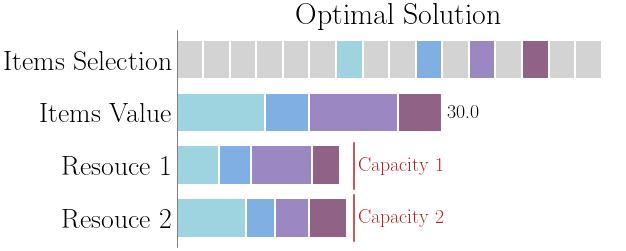

In [12]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # convert to numpy
    x = x.to("cpu").detach().numpy()[0]
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    if i == ind:
        fig = plotSol(m, c*5, w, weights, caps, "Optimal Solution")
        fig.savefig("../images/ins-ks2-opt.pdf", dpi=300)
        break

## Two-Stage 

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
# prediction model
reg = LinearRegression()
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [15]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

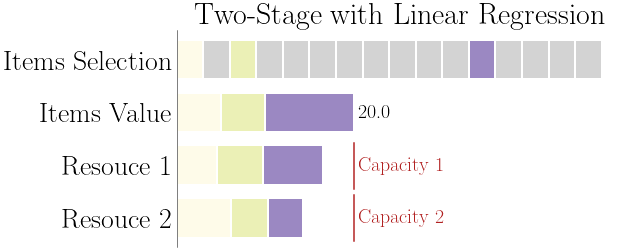

In [16]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    # predict
    cp = twostage_model.predict(x)
    if i == ind:
        # solve
        optmodel.setObj(cp[0])
        wp, _ = optmodel.solve()
        fig = plotSol(m, c*5, wp, weights, caps, "Two-Stage with Linear Regression")
        fig.savefig("../images/ins-ks2-2s.pdf", dpi=300)
        break

## SPO+ 

In [17]:
from torch import nn

In [18]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [19]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [20]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [21]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(optmodel, processes=4)

Num of cores: 4


In [ ]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, optmodel, ks_loader_test)
        loss_log_truespo.append(trueloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), trueloss*100))

Epoch  10, Loss:  20.0415, Regret: 33.4131%
Epoch  20, Loss:  16.0724, Regret: 26.6699%
Epoch  30, Loss:  19.4699, Regret: 20.8350%
Epoch  40, Loss:  33.8244, Regret: 16.6897%
Epoch  50, Loss:  23.2868, Regret: 14.1367%
Epoch  60, Loss:  10.2983, Regret: 12.2454%
Epoch  70, Loss:   4.9857, Regret: 10.5334%
Epoch  80, Loss:  12.4501, Regret: 10.0288%
Epoch  90, Loss:   9.1206, Regret:  9.2887%
Epoch 100, Loss:  16.6739, Regret:  8.7018%
Epoch 110, Loss:   8.7204, Regret:  8.4028%
Epoch 120, Loss:  13.7454, Regret:  8.3505%
Epoch 130, Loss:   9.9317, Regret:  8.3505%
Epoch 140, Loss:   4.6244, Regret:  8.2122%
Epoch 150, Loss:  11.2529, Regret:  8.2608%
Epoch 160, Loss:   7.0274, Regret:  8.1337%
Epoch 170, Loss:  11.8399, Regret:  8.0440%
Epoch 180, Loss:  21.1049, Regret:  7.9954%
Epoch 190, Loss:  12.5131, Regret:  7.9842%
Epoch 200, Loss:  12.3924, Regret:  7.4833%
Epoch 210, Loss:   3.5411, Regret:  7.5917%
Epoch 220, Loss:   2.9533, Regret:  7.4646%
Epoch 230, Loss:   6.9364, Regre

In [ ]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()[0]
    w = w.to("cpu").detach().numpy()[0]
    z = z.to("cpu").detach().numpy()[0]
    cp = cp.to("cpu").detach().numpy()
    if i == ind:
        # solve
        optmodel.setObj(cp[0])
        wp, _ = optmodel.solve()
        print(wp)
        fig = plotSol(m, c*5, wp, weights, caps, "SPO+")
        fig.savefig("../images/ins-ks2-spo.pdf", dpi=300)
        break